In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
eps = 0.1
t = 80000 # Amount of samples to generate from the target distribution
nstep = 50 # Amount of leapfrog steps used for the simulation of the hamiltonian
xStep = 0.05 # Used for plotting the real distribution
m = 1
C = 3  # Friction (damping)
V = 4
theta_init = 0

np.random.seed(10)

In [4]:
# Define energy and gradient
def U(theta):
    return -2 * theta**2 + theta**4

def gradUPerfect(theta):
    grad = -4 * theta + 4 * theta**3
    return grad

def gradU(theta):
    noise = np.random.randn() * 2 #np.random.normal(0, eps * np.sqrt(V))  # ∼ ε√V
    return gradUPerfect(theta) + noise


## True distribution

In [5]:
xGrid = np.arange(-2, 2 + xStep, xStep)
true_pdf = np.exp(-U(xGrid))
true_pdf /= np.sum(true_pdf) * xStep

## HMC

In [6]:
def hmc(U, gradU, M, eps, nstep, x, mhtest):
    r = np.random.randn() * np.sqrt(M)
    current_x = x
    current_energy = 0.5 * r**2 / M + U(x)

    # Leapfrog algorithm
    #r -= 0.5 * eps * gradU(x)
    
    for _ in range(nstep):
        r = r - gradU(x)* eps/2
        x += eps * r / M
        r = r - gradU(x)* eps/2

        #if _ != nstep - 1:
            #r = r - gradU(x) * eps

    #r -= 0.5 * eps * gradU(x)
    r = -r

    # MH test
    new_energy = 0.5 * r**2 / M + U(x)
    if mhtest and np.random.rand() > np.exp(current_energy - new_energy):
        x = current_x  # reject

    return x


## SGHMC

In [7]:
def sghmc(U, gradU, m, eps, nstep, x, C, V):
    r = np.random.randn() * np.sqrt(m)
    B = 0.5 * V * eps
    D = np.sqrt(2 * (C - B) * eps)
    for _ in range(nstep):
        r = r - eps * gradU(x) - eps * C * r / m + np.random.randn() * D
        x += eps * r / m
    return x


In [8]:

def run_sampler(grad_func, mh, sampler_func):
    samples = []
    x = theta_init
    for _ in range(t):
        x = sampler_func(U, grad_func, m, eps, nstep, x, mh) if sampler_func == hmc else sampler_func(U, grad_func, m, eps, nstep, x, C, V)
        samples.append(x)
        
    hist, edges = np.histogram(samples, bins=xGrid, density=True)
    centers = (edges[:-1] + edges[1:]) / 2

    return centers, hist


In [9]:
centers_hmc_mh, hist_hmc_mh = run_sampler(gradUPerfect, True, hmc)
centers_hmc, hist_hmc = run_sampler(gradUPerfect, False, hmc)
centers_nhmc_mh, hist_nhmc_mh = run_sampler(gradU, True, hmc)
centers_nhmc, hist_nhmc = run_sampler(gradU, False, hmc)
centers_sghmc, hist_sghmc = run_sampler(gradU, False, sghmc)

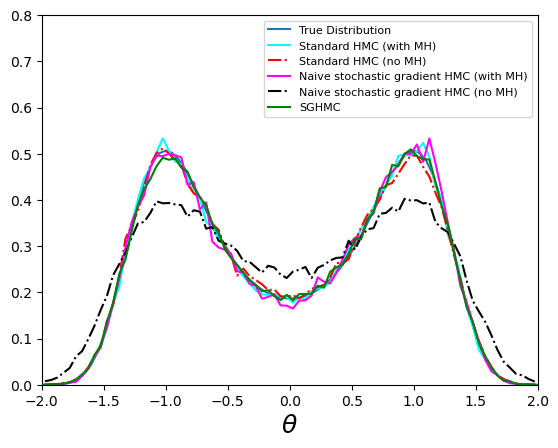

In [10]:
plt.figure()
plt.plot(xGrid, true_pdf, label="True Distribution")
plt.plot(centers_hmc_mh, hist_hmc_mh, label="Standard HMC (with MH)", color="cyan", linestyle='-')
plt.plot(centers_hmc, hist_hmc, label="Standard HMC (no MH)", color="red", linestyle='-.')
plt.plot(centers_nhmc_mh, hist_nhmc_mh, label="Naive stochastic gradient HMC (with MH)", color="magenta", linestyle='-')
plt.plot(centers_nhmc, hist_nhmc, label="Naive stochastic gradient HMC (no MH)", color="black", linestyle='-.')
plt.plot(centers_sghmc, hist_sghmc, label="SGHMC", color="green", linestyle='-')


plt.xlim(-2, 2)
plt.ylim(0, 0.8)
plt.xlabel(r'$\theta$', fontsize=18)
plt.legend(loc="upper right", fontsize=8)
plt.show()

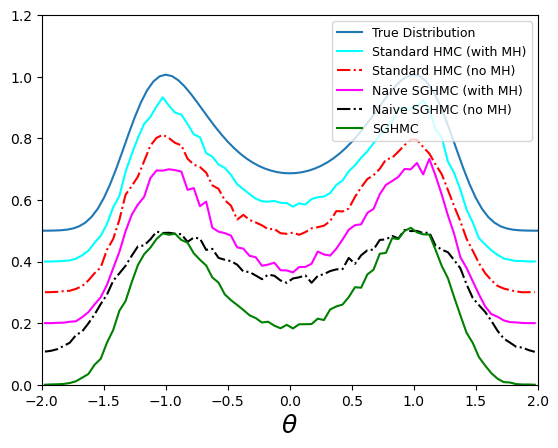

In [11]:
offsets = [0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

plt.figure()
plt.plot(xGrid, true_pdf+ offsets[0], label="True Distribution")
plt.plot(centers_hmc_mh, hist_hmc_mh+ offsets[1], label="Standard HMC (with MH)", color="cyan", linestyle='-')
plt.plot(centers_hmc, hist_hmc+ offsets[2], label="Standard HMC (no MH)", color="red", linestyle='-.')
plt.plot(centers_nhmc_mh, hist_nhmc_mh+ offsets[3], label="Naive SGHMC (with MH)", color="magenta", linestyle='-')
plt.plot(centers_nhmc, hist_nhmc+ offsets[4], label="Naive SGHMC (no MH)", color="black", linestyle='-.')
plt.plot(centers_sghmc, hist_sghmc+ offsets[5], label="SGHMC", color="green", linestyle='-')


plt.xlim(-2, 2)
plt.ylim(0, 1.2)
plt.xlabel(r'$\theta$', fontsize=18)
plt.legend(loc="upper right", fontsize=9)
plt.show()